In [80]:
%matplotlib inline

In [81]:
import numpy as np

import matplotlib.pyplot as plt

In [82]:

class SGD:
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
    def update(self, params, grads):
        return params - self.lr * grads

In [83]:
class Momentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.lr = learning_rate
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = np.zeros_like(params)
        self.v = self.momentum * self.v - self.lr * grads
        return params + self.v

In [84]:
class RMSProp:
    def __init__(self, learning_rate=0.001, rho=0.9, epsilon=1e-8):
        self.lr = learning_rate
        self.rho = rho
        self.epsilon = epsilon
        self.cache = None
    def update(self, params, grads):
        if self.cache is None:
            self.cache = np.zeros_like(params)
        self.cache = self.rho * self.cache + (1 - self.rho) * grads**2
        return params - self.lr * grads / (np.sqrt(self.cache) + self.epsilon)

In [85]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.m = None
        self.v = None
    def update(self, params, grads):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        params -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return params

In [86]:
class AdamW:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.t = 0
        self.m = None
        self.v = None
    def update(self, params, grads):
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        # Правильный порядок: сначала weight decay, потом градиентный шаг
        params = params * (1 - self.lr * self.weight_decay)
        params -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return params


In [87]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def forward(X, W, b):
    return sigmoid(X @ W + b)

def compute_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def compute_gradients(X, y_true, y_pred):
    m = X.shape[0]
    dZ = y_pred - y_true
    dW = (X.T @ dZ) / m
    db = np.sum(dZ) / m
    return dW, db

In [88]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y = np.array([[0], [0], [1], [1]], dtype=np.float32)

In [89]:
def train_model(optimizer_class, **kwargs):
    np.random.seed(42)
    W = np.random.randn(2, 1) * 0.01
    b = np.zeros((1, 1))
    opt_W = optimizer_class(**kwargs)
    opt_b = optimizer_class(**kwargs)
    losses = []
    for _ in range(500):
        y_pred = forward(X, W, b)
        loss = compute_loss(y, y_pred)
        losses.append(loss)
        dW, db = compute_gradients(X, y, y_pred)
        W = opt_W.update(W, dW)
        b = opt_b.update(b, db)
    return losses

# Обучаем все модели
losses_sgd = train_model(SGD, learning_rate=0.1)
losses_momentum = train_model(Momentum, learning_rate=0.05, momentum=0.9)
losses_rmsprop = train_model(RMSProp, learning_rate=0.01)
losses_adam = train_model(Adam, learning_rate=0.1)
losses_adamw = train_model(AdamW, learning_rate=0.1, weight_decay=0.01)


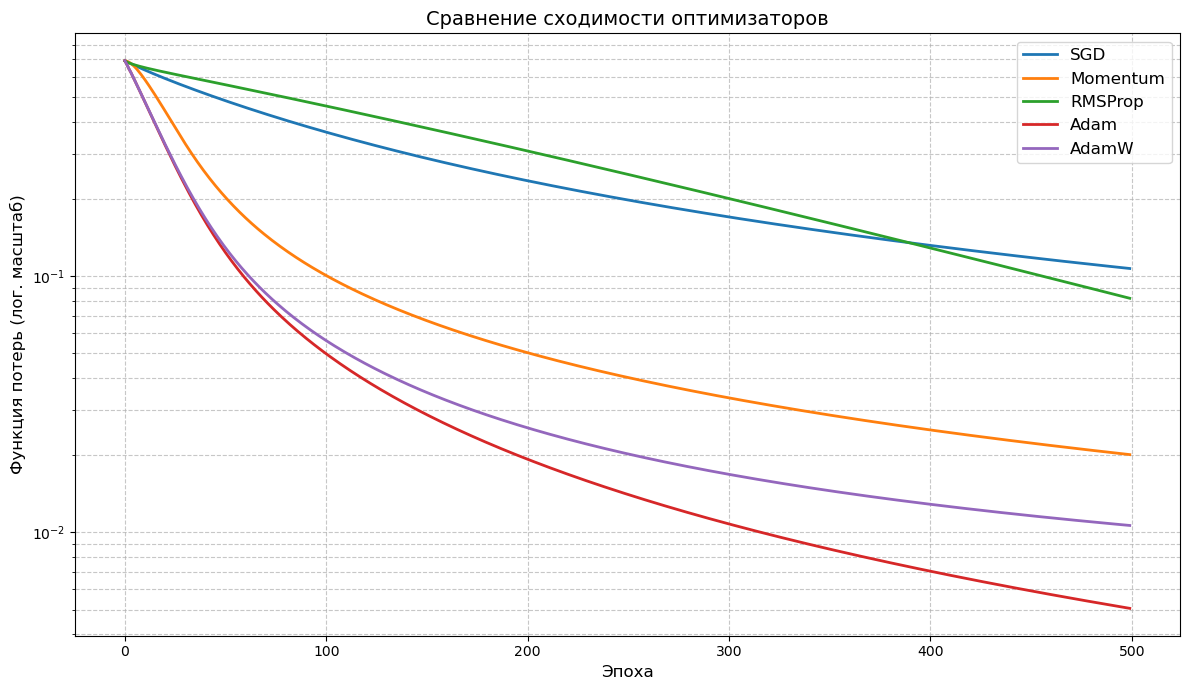

In [90]:
plt.figure(figsize=(12, 7))
plt.plot(losses_sgd, label='SGD', linewidth=2)
plt.plot(losses_momentum, label='Momentum', linewidth=2)
plt.plot(losses_rmsprop, label='RMSProp', linewidth=2)
plt.plot(losses_adam, label='Adam', linewidth=2)
plt.plot(losses_adamw, label='AdamW', linewidth=2)
plt.yscale('log')
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Функция потерь (лог. масштаб)', fontsize=12)
plt.title('Сравнение сходимости оптимизаторов', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show() 

In [91]:
print("Финальные значения функции потерь:")
print(f"SGD      : {losses_sgd[-1]:.2e}")
print(f"Momentum : {losses_momentum[-1]:.2e}")
print(f"RMSProp  : {losses_rmsprop[-1]:.2e}")
print(f"Adam     : {losses_adam[-1]:.2e}")
print(f"AdamW    : {losses_adamw[-1]:.2e}")

Финальные значения функции потерь:
SGD      : 1.07e-01
Momentum : 2.01e-02
RMSProp  : 8.19e-02
Adam     : 5.05e-03
AdamW    : 1.06e-02
